In [157]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb

In [158]:
# Parametri di simulazione
TimeSplit_up = "2025-01-01"
TimeSplit_down = "2023-12-18"
starting_cash = 1000
window = 40

In [159]:
# --- Carica dati e modello ---
with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

models = {}

start_dt = pd.to_datetime(TimeSplit_down)
end_dt = pd.to_datetime(TimeSplit_up)

for tiker in stocks:
    df = pd.read_csv(
        f"csv/{tiker}_indicators.csv",
        index_col=0,
        parse_dates=[0],
        date_format="ISO8601"
    )

    bundle = joblib.load(f"models/{tiker}.joblib")
    scaler = bundle.get("scaler", None)  # legacy
    model = bundle["model"]
    features = bundle["features"]
    print(features)
    aggressive = bundle.get("aggressive", bundle.get("aggresive", None))
    threshold = bundle.get("threshold", bundle.get("threshodl", None))

    test_slice = df.loc[(df.index >= start_dt) & (df.index <= end_dt)].copy()
  
    entry = {
        "model": model,
        "features": features,
        "test_data": test_slice
    }

    if aggressive is not None:
        entry["aggressive"] = aggressive
        lookback_start = start_dt - pd.Timedelta(days=window)
        warm = df.loc[(df.index > lookback_start) & (df.index < start_dt)].copy()
        # Sono gli ultimi 40 giorni di validation usati per costruire correttamente
        # il warm start sul test set
        entry["aggressive_warm_start_sample"] = warm.copy()
    if threshold is not None:
        entry["threshold"] = threshold

    models[tiker] = entry

['High', 'Volume', 'Return', 'MACD', 'MACD_Signal', 'MACD_Hist', 'EMA20', 'Vol_EMA20', 'RSI', 'Boll_Up', 'Boll_Down', 'Dist_low_band', 'Dist_up_band', '%K', '%D', 'R_EMA20', 'ADX', '+DI', '-DI', 'ATR', 'BB_pctB', 'ROC', 'OBV', 'CMF', 'MACD_norm', 'RSI_diff', 'DI_diff', 'SMA_slope', 'RSI_slope', 'MACD_slope', '%K_slope', '%D_slope', 'ATR_slope', 'OBV_slope', 'ADX_slope', 'RSI_overbought', 'RSI_oversold', 'Stoch_overbought', 'Stoch_oversold', 'MACD_crossover_signal', 'Vol_pct_change', 'RSI_x_Vol_Change', 'ATR_pct', 'RSI_SMA15', 'RSI_vs_SMA', 'MACD_Hist_Std20', 'SP_Return', 'SP_RSI', 'SP_Dist_SMA']


In [160]:
# Baseline: Buy and Hold
for tiker, data in models.items():
    print("=" * 10 + f"{tiker}" + "=" * 10)

    own_tikers = starting_cash / data["test_data"].iloc[0]["Close"]
    payout_bnh = own_tikers * data["test_data"].iloc[-1]["Close"]

==========AAPL==========


In [161]:
# Baseline: Trend Chaser 
for ticker, data in models.items():
    print("=" * 10 + f"{ticker}" + "=" * 10)
    
    trend_chaser = {
        "cash": starting_cash,
        "shares": 0.0,
        "prev_price": None,
        "up_streak": 0,      
        "down_streak": 0,    
        "threshold": 2,     
        "data": data["test_data"].copy()
    }

    def step(row):
        price = float(row["Close"])
        prev = trend_chaser["prev_price"]

        # Inizializza alla prima riga
        if prev is None:
            trend_chaser["prev_price"] = price
            portfolio = trend_chaser["cash"] + trend_chaser["shares"] * price
            return portfolio

        # Aggiorna le streak in base al movimento del prezzo
        if price > prev:
            trend_chaser["up_streak"] += 1
            trend_chaser["down_streak"] = 0
        elif price < prev:
            trend_chaser["down_streak"] += 1
            trend_chaser["up_streak"] = 0
        # Se price == prev, mantieni le streak correnti
        
        # Segnale di acquisto: forte trend al rialzo rilevato e abbiamo liquidità
        if (trend_chaser["up_streak"] >= trend_chaser["threshold"] and 
            trend_chaser["cash"] > 0):
            shares_to_buy = trend_chaser["cash"] / price
            trend_chaser["shares"] += shares_to_buy
            trend_chaser["cash"] = 0.0
        
        # Segnale di vendita: forte trend al ribasso rilevato e abbiamo azioni
        elif (trend_chaser["down_streak"] >= trend_chaser["threshold"] and 
              trend_chaser["shares"] > 0):
            cash_from_sale = trend_chaser["shares"] * price
            trend_chaser["cash"] += cash_from_sale
            trend_chaser["shares"] = 0.0

        trend_chaser["prev_price"] = price
        portfolio = trend_chaser["cash"] + trend_chaser["shares"] * price

        return portfolio
    
    trend_chaser["data"].loc[:, "portfolio_value"] = trend_chaser["data"].apply(step, axis=1)
    
    print(len(trend_chaser["data"]))
    # Calcola il payout finale
    final_price = trend_chaser["data"].iloc[-1]["Close"]
    payout_tc = trend_chaser["cash"] + (trend_chaser["shares"] * final_price)

==========AAPL==========
261


In [162]:
floor_probability = 0.40

# Strategia del modello
for ticker, data in models.items():
    print("=" * 10 + f"{ticker}" + "=" * 10)

    model_state = {
        "model": data["model"],
        "cash": starting_cash,
        "shares": 0.0,
        "streak": 0,
        "buy_price": 0,
        "max_price": 0
    }
    # model è il modello caricato
    model = model_state["model"]
    model_state["data"] = data["test_data"]

    if "aggressive" in data:
        model_state["aggressive"] = data["aggressive"]
        # Concatenazione dei dati per allineare le feature e le threshold
        temp = pd.concat([data["aggressive_warm_start_sample"], data["test_data"]]).reset_index(drop=True)  # type: ignore
        work_data = temp[data["features"]].copy()

        # Trasformazione in Dmatrix e predizione
        dmatrix = xgb.DMatrix(work_data.values, feature_names=data["features"])
        probability = model.predict(dmatrix, iteration_range=(0, model.best_iteration))
        probability_series = pd.Series(probability).astype(float)

        # Calcolo della threshold dinamica
        roll_mean = probability_series.rolling(window=window).mean()
        roll_std = probability_series.rolling(window=window).std()
        dynamic_threshold = roll_mean + roll_std.mul(float(data["aggressive"]))
        dynamic_threshold = np.maximum(dynamic_threshold, floor_probability)
        dynamic_threshold = dynamic_threshold.iloc[len(data["aggressive_warm_start_sample"]):].reset_index(drop=True)  # type: ignore
        probability_series = probability_series.iloc[len(data["aggressive_warm_start_sample"]):].reset_index(drop=True)

        actions = (probability_series > dynamic_threshold).astype(int)
    else:
        
        if "threshold" in data:
            model_state["threshold"] = data["threshold"]
        else:
            model_state["threshold"] = 0.5

        work_data = model_state["data"].loc[:, data["features"]].copy()
        dmatrix = xgb.DMatrix(work_data.values, feature_names=data["features"])
        probability = model.predict(dmatrix)
        actions = pd.Series((probability >= model_state["threshold"]).astype(int), index=work_data.index)


    print(len(model_state["data"]))
    print(len(actions))

    model_state["data"].loc[:, "model_action"] = actions.values

    def model(row):
        price = float(row["Close"])

        if row["model_action"] == 1:
            model_state["streak"] = 0
            if model_state["shares"] == 0:
                #hard buy
                model_state["max_price"] = price
                model_state["buy_price"] = price
                model_state["shares"] += model_state["cash"] / price
                model_state["cash"] = 0.0
                model_state["streak"] = 0
            
        if row["model_action"] == 0:
            model_state["streak"] += 1
            if model_state["shares"] != 0 and (model_state["streak"] >= 5):
                #Hard sell
                model_state["cash"] += model_state["shares"] * price
                model_state["shares"] = 0.0
                model_state["streak"] = 0

        return model_state["cash"] + (model_state["shares"] * price)



    model_state["data"].loc[:, "model_value"] = model_state["data"].apply(model, axis=1)
    # payout finale
    payout_mod = model_state["cash"] + (model_state["shares"] * model_state["data"].iloc[-1]["Close"])

==========AAPL==========
261
261


Baseline 1: Soldi di partenza: 1000 | Soldi alla fine 1278.3705086997843 | Guadagno 27.837 %
Baseline 2: Soldi di partenza: 1000 | Soldi alla fine 1108.4841206593292 | Guadagno 10.848 %
Modello: Soldi di partenza: 1000 | Soldi alla fine 1279.7599622275336 | Guadagno 27.976 %


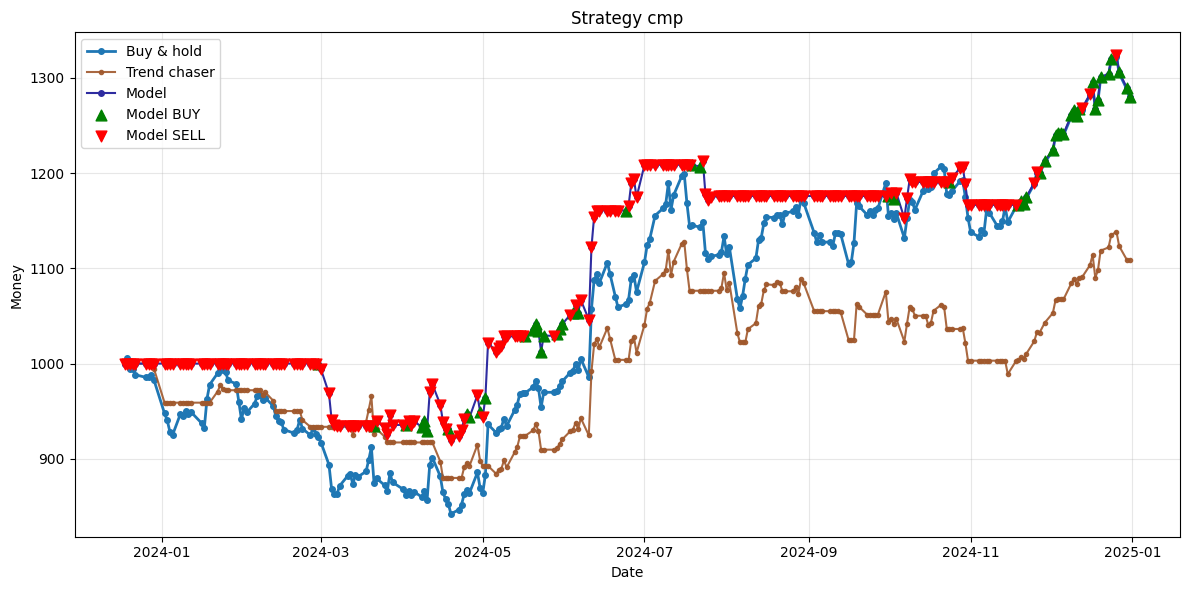

In [163]:
print(f"Baseline 1: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_bnh} | Guadagno {((payout_bnh - starting_cash)/starting_cash) * 100:.3f} %")
print(f"Baseline 2: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_tc} | Guadagno {((payout_tc - starting_cash)/starting_cash) * 100:.3f} %")
print(f"Modello: Soldi di partenza: {starting_cash} | Soldi alla fine {payout_mod} | Guadagno {((payout_mod - starting_cash)/starting_cash) * 100:.3f} %")

plt.figure(figsize=(12,6))

idx = data["test_data"].index
bh_series = data["test_data"]["Close"] * own_tikers
tc_series = trend_chaser["data"]["portfolio_value"]
model_series = model_state["data"]["model_value"]


plt.plot(idx, bh_series, label='Buy & hold', color='#1f77b4', linewidth=2, marker='o', markersize=4)
plt.plot(idx, tc_series, label='Trend chaser', color="#a0582c", linewidth=1.5, marker='o', markersize=3, alpha=0.9)
plt.plot(idx, model_series, label='Model', color="#2e2ca0", linewidth=1.5, marker='o', markersize=4)

# Inserimento delle valutazioni del modello (^ or v)
buys = model_state["data"]["model_action"] == 1
sells = model_state["data"]["model_action"] == 0

plt.scatter(model_state["data"].loc[buys].index, model_state["data"].loc[buys, "model_value"],
            marker="^", color="green", s=60, label="Model BUY", zorder=5)
plt.scatter(model_state["data"].loc[sells].index, model_state["data"].loc[sells, "model_value"], marker="v", color="red", s=60, label="Model SELL", zorder=5)

plt.title("Strategy cmp")
plt.xlabel("Date")
plt.ylabel("Money")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

==========AAPL - Confusion Matrix==========
Using DYNAMIC threshold (aggressive=1.1)

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.56      0.26      0.36       102
           0       0.64      0.86      0.73       154

    accuracy                           0.62       256
   macro avg       0.60      0.56      0.55       256
weighted avg       0.61      0.62      0.59       256

Total Trades: 48 out of 256 days


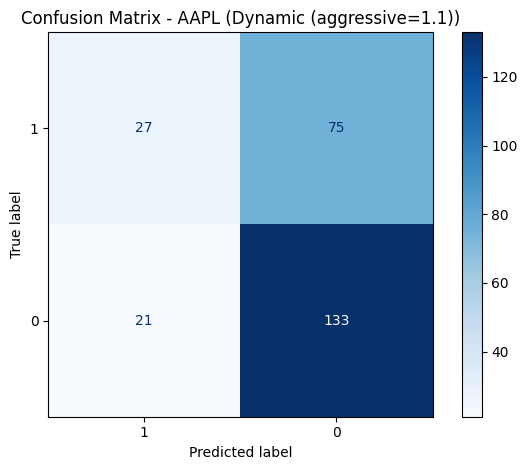

In [164]:
import importlib
import target
importlib.reload(target)
from target import calculate_target
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

for ticker, data in models.items():
    print("=" * 10 + f"{ticker} - Confusion Matrix" + "=" * 10)
    
    test_df = data["test_data"].copy()

    test_df['Target'] = calculate_target(test_df, profit_take_pct=2, stop_loss_pct=1.0)
    test_df = test_df.dropna(subset=["Target"])
    test_df['Target'] = test_df['Target'].astype(int)

    if "aggressive" in data:
        temp = pd.concat([data["aggressive_warm_start_sample"], data["test_data"]]).reset_index(drop=True)
        work_data = temp[data["features"]].copy()

        dmatrix = xgb.DMatrix(work_data.values, feature_names=data["features"])
        probability = data["model"].predict(dmatrix, iteration_range=(0, data["model"].best_iteration))
        probability_series = pd.Series(probability).astype(float)

        roll_mean = probability_series.rolling(window=window).mean()
        roll_std = probability_series.rolling(window=window).std()
        dynamic_threshold = roll_mean + roll_std.mul(float(data["aggressive"]))
        dynamic_threshold = np.maximum(dynamic_threshold, floor_probability)
        
        # Align with test_df AFTER dropping NaN targets
        start_idx = len(data["aggressive_warm_start_sample"])
        probability_series = probability_series.iloc[start_idx:start_idx + len(test_df)].reset_index(drop=True)
        dynamic_threshold = dynamic_threshold.iloc[start_idx:start_idx + len(test_df)].reset_index(drop=True)
        
        test_df['Probability'] = probability_series.values
        test_df['Dynamic_Threshold'] = dynamic_threshold.values
        test_df['Prediction'] = (probability_series > dynamic_threshold).astype(int).values
        
        threshold_info = f"Dynamic (aggressive={data['aggressive']:.1f})"
        print(f"Using DYNAMIC threshold (aggressive={data['aggressive']:.1f})")
    else:
        if "threshold" in data:
            threshold = data["threshold"]
        else:
            threshold = 0.5
        
        work_data = test_df.loc[:, data["features"]].copy()
        dmatrix = xgb.DMatrix(work_data.values, feature_names=data["features"])
        probability = data["model"].predict(dmatrix)
        
        test_df['Probability'] = probability
        test_df['Prediction'] = (probability >= threshold).astype(int)
        
        threshold_info = f"Static (threshold={threshold})"
        print(f"Using STATIC threshold={threshold}")

    test_df = test_df.dropna(subset=["Target"])
    test_df['Target'] = test_df['Target'].astype(int)

    predictions = test_df['Prediction'].values
    targets = test_df['Target'].values

    print("\nClassification Report (Test Set):")
    print(classification_report(targets, predictions, labels=[1, 0]))
    print(f"Total Trades: {predictions.sum()} out of {len(predictions)} days")

    cm = confusion_matrix(targets, predictions, labels=[1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {ticker} ({threshold_info})")
    plt.tight_layout()
    plt.show()
    